In [2]:
# phishing_mlp_keras.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [3]:
# 1. Load Data
df = pd.read_csv('D:/project_training_code/phishing.csv')
df = df.drop(columns=['Index'])
df['class'] = df['class'].map({-1: 0, 1: 1})  # 0 = legitimate, 1 = phishing

✅ Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11054 entries, 0 to 11053
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   UsingIP              11054 non-null  int64
 1   LongURL              11054 non-null  int64
 2   ShortURL             11054 non-null  int64
 3   Symbol@              11054 non-null  int64
 4   Redirecting//        11054 non-null  int64
 5   PrefixSuffix-        11054 non-null  int64
 6   SubDomains           11054 non-null  int64
 7   HTTPS                11054 non-null  int64
 8   DomainRegLen         11054 non-null  int64
 9   Favicon              11054 non-null  int64
 10  NonStdPort           11054 non-null  int64
 11  HTTPSDomainURL       11054 non-null  int64
 12  RequestURL           11054 non-null  int64
 13  AnchorURL            11054 non-null  int64
 14  LinksInScriptTags    11054 non-null  int64
 15  ServerFormHandler    11054 non-null  int64
 16  InfoEm

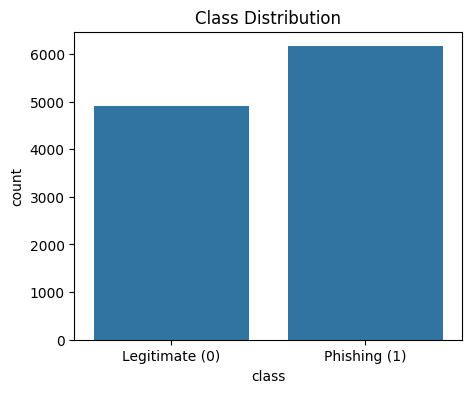

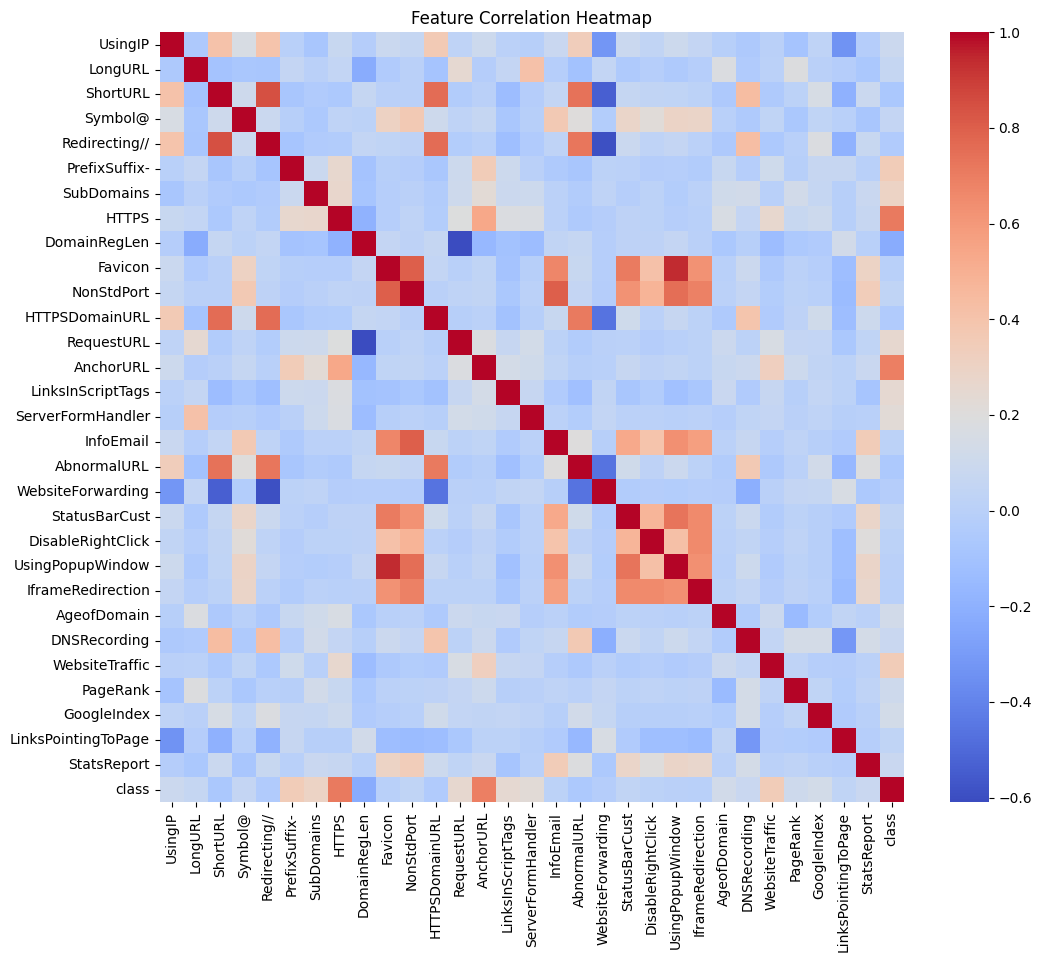

In [4]:
# 2. EDA
print("✅ Dataset Info:")
print(df.info())

print("\n📊 Class Distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='class', data=df)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Legitimate (0)', 'Phishing (1)'])
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
# 3. Prepare Data
X = df.drop(columns=['class']).values
y = df['class'].values

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42)

# Scale continuous columns only
cont_idx = [df.columns.get_loc(c) for c in ['DomainRegLen', 'PageRank', 'WebsiteTraffic', 'StatsReport', 'AgeofDomain']]
scaler = StandardScaler()
X_train[:, cont_idx] = scaler.fit_transform(X_train[:, cont_idx])
X_val[:, cont_idx] = scaler.transform(X_val[:, cont_idx])
X_test[:, cont_idx] = scaler.transform(X_test[:, cont_idx])



In [6]:
# 4. Model Definition
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [7]:
# 5. Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64, callbacks=[es])



Epoch 1/30
121/121 [==============================] - 6s 12ms/step - loss: 0.3853 - accuracy: 0.8377 - val_loss: 0.1808 - val_accuracy: 0.9343
Epoch 2/30
121/121 [==============================] - 1s 6ms/step - loss: 0.2311 - accuracy: 0.9121 - val_loss: 0.1584 - val_accuracy: 0.9439
Epoch 3/30
121/121 [==============================] - 1s 5ms/step - loss: 0.2051 - accuracy: 0.9227 - val_loss: 0.1436 - val_accuracy: 0.9427
Epoch 4/30
121/121 [==============================] - 1s 5ms/step - loss: 0.1874 - accuracy: 0.9254 - val_loss: 0.1422 - val_accuracy: 0.9481
Epoch 5/30
121/121 [==============================] - 1s 6ms/step - loss: 0.1763 - accuracy: 0.9276 - val_loss: 0.1399 - val_accuracy: 0.9524
Epoch 6/30
121/121 [==============================] - 1s 5ms/step - loss: 0.1668 - accuracy: 0.9328 - val_loss: 0.1291 - val_accuracy: 0.9511
Epoch 7/30
121/121 [==============================] - 1s 6ms/step - loss: 0.1626 - accuracy: 0.9354 - val_loss: 0.1240 - val_accuracy: 0.9548
Epoch

In [ ]:
# 6. Evaluate on training set
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"\n✅ Train Accuracy: {train_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy:  {test_acc:.4f}")



✅ Train Accuracy: 0.9683
✅ Test Accuracy:  0.9560


52/52 [==============================] - 0s 3ms/step


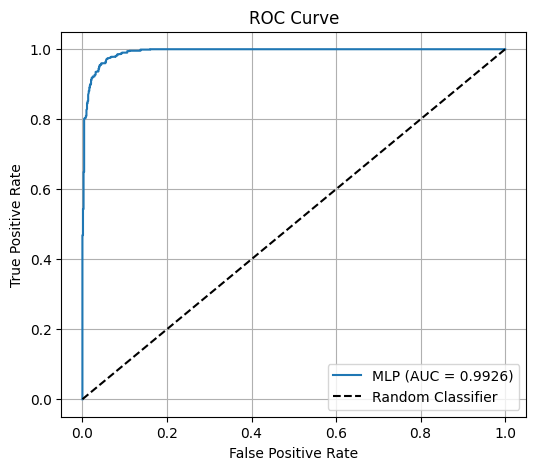

In [10]:
# 7. ROC Curve
y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



In [11]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, accuracy_score
)

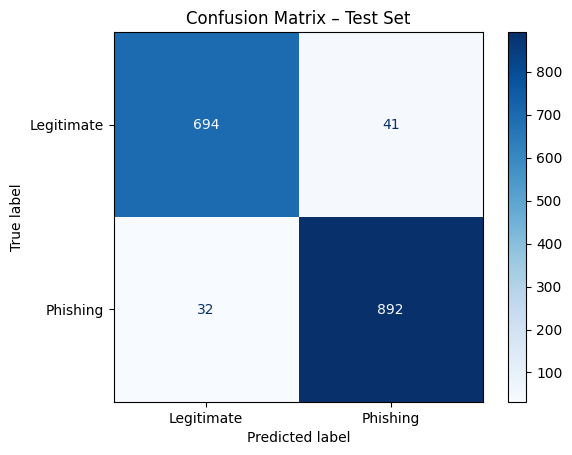

In [12]:
y_pred_classes = (y_probs > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Test Set")
plt.grid(False)
plt.show()

In [13]:
# 8. Save Keras Model
model.save('phishing_model.h5')
print("📦 Saved Keras model as phishing_model.h5")

📦 Saved Keras model as phishing_model.h5


In [14]:
# 9. Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("phishing_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Converted and saved TFLite model as phishing_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\hrsan\AppData\Local\Temp\tmpf75wmw_e\assets
✅ Converted and saved TFLite model as phishing_model.tflite
